In [1]:
import numpy as np
import sys
from Dataset.TrainDatasetConstructor import TrainDatasetConstructor
from Dataset.EvalDatasetConstructor import EvalDatasetConstructor
from eval.eval_as_a_whole import eval_model
from metrics import AEBatch, SEBatch
import time
from model import MaxDilatedCSRNet
import torch
%matplotlib inline

In [2]:
config = {
'SHANGHAITECH': 'A',
'min_RATE':10000000,
'min_MAE':10240000,
'min_MSE':10240000,
'eval_num':182,
'train_num':300,
'learning_rate': 1e-6,
'train_batch_size': 1,
'epoch': 1000,
'eval_per_step': 300,
'mode':'whole'
}
img_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/images"
gt_dir = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/train_data/gt_map"

img_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/images"
gt_dir_t = "/home/zzn/Documents/Datasets/part_" + config['SHANGHAITECH'] + "_final/test_data/gt_map"

In [3]:
model_save_path = "/home/zzn/PycharmProjects/MaxDilation_pytorch/checkpoints/model_1.pkl"
train_dataset = TrainDatasetConstructor(img_dir, gt_dir, train_num=config['train_num'],
                 mode=config['mode'],
                 if_random_hsi=True,
                 if_flip=True)
eval_dataset = EvalDatasetConstructor(img_dir_t, gt_dir_t, validate_num=config['eval_num'],
                 mode=config['mode'])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config['train_batch_size'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [4]:
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda")

net = MaxDilatedCSRNet().cuda()

optimizer = torch.optim.Adam(net.parameters(), config['learning_rate'])
# optimizer = torch.optim.SGD(net.parameters(), 1e-7, 0.95, 5e-4)
criterion = torch.nn.MSELoss(reduction='sum').cuda()
ae_batch = AEBatch().cuda()
se_batch = SEBatch().cuda()
modules = {'model':net, 'loss':criterion, 'ae':ae_batch, 'se':se_batch}

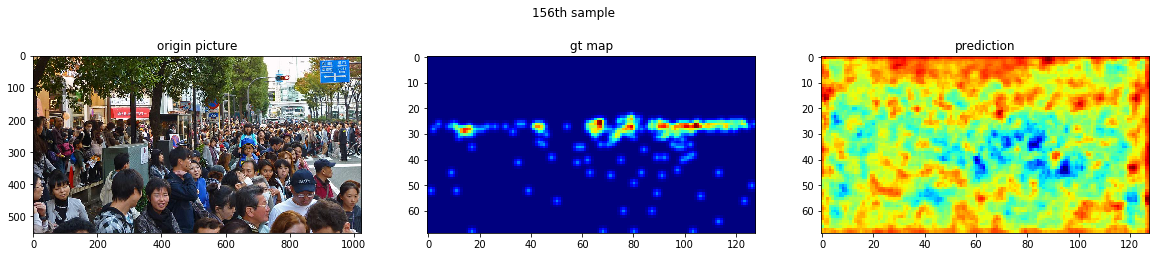

The gt counts of the above sample:197.3762969970703, and the pred counts:-1217.12158203125
In step 0, epoch 1, MAE = 1454.235595703125, MSE = 1595.8267822265625, time cost = 9.836623430252075.
In step 300, the loss = 178.80199570814767, time_cost_epoch = 53.39090275764465


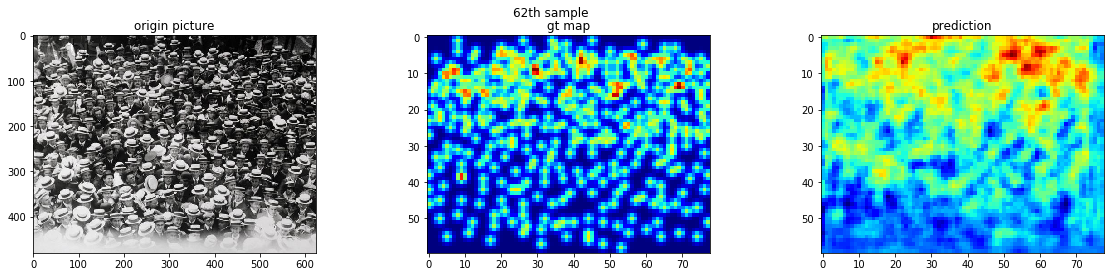

The gt counts of the above sample:333.0527648925781, and the pred counts:224.46963500976562
In step 300, epoch 2, MAE = 156.0840301513672, MSE = 246.7451934814453, time cost = 8.441479206085205.
In step 600, the loss = 126.58351741313935, time_cost_epoch = 53.677953481674194


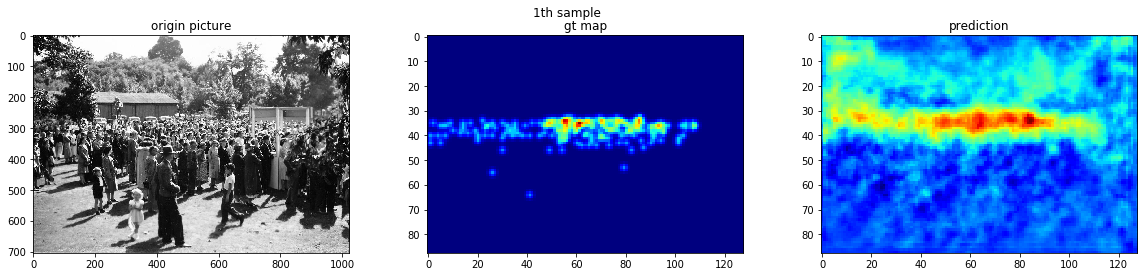

The gt counts of the above sample:171.87867736816406, and the pred counts:763.7664184570312
In step 600, epoch 3, MAE = 225.59945678710938, MSE = 280.48724365234375, time cost = 8.491373777389526.


In [ ]:
step = 0
# torch.cuda.empty_cache()
for epoch_index in range(config['epoch']):
    dataset = train_dataset.shuffle()
    loss_list = []
    time_per_epoch = 0
    
    for train_img_index, train_img, train_gt in train_loader:
        if step % config['eval_per_step'] == 0:
            validate_MAE, validate_RMSE, time_cost = eval_model(config, eval_loader, modules, True)
            sys.stdout.write('In step {}, epoch {}, MAE = {}, MSE = {}, time cost = {}.\n'.format(step, epoch_index + 1, validate_MAE, validate_RMSE, time_cost))
            sys.stdout.flush()
            
            #save model
            if config['min_MAE'] > validate_MAE:
                config['min_MAE'] = validate_MAE
                torch.save(net, model_save_path)
#             # return train model
        net.train()
        optimizer.zero_grad()
        # B
        x = train_img
        y = train_gt
        start = time.time()
        prediction = net(x)
        loss = criterion(prediction, y)
        loss_list.append(loss.data.item())
        loss.backward()
        optimizer.step()
        step += 1
        torch.cuda.synchronize()
        end2 = time.time()
        time_per_epoch += end2 - start
    loss_epoch_mean = np.mean(loss_list)
    sys.stdout.write('In step {}, the loss = {}, time_cost_epoch = {}\n'.format(step, loss_epoch_mean,  time_per_epoch))
    sys.stdout.flush()